# Look at the product of the Hilbert transform vs. actual phase signal

In [1]:
%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn.image import mean_img
from nilearn.input_data import NiftiSpheresMasker
from nilearn.masking import compute_epi_mask, apply_mask
from nilearn.plotting import plot_epi
from scipy.signal import hilbert

sys.path.append('/Users/tsalo/Documents/tsalo/complex-flow/')
from complex_utils import to_radians

In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
def to_complex(mag, phase):
    real = mag / np.sqrt(np.tan(phase) ** 2 + 1)
    imag = np.tan(phase) * real
    comp = real + (1j * imag)
    return comp

In [3]:
m = ('/Users/tsalo/Documents/Laird_DIVA/'
     'dset/sub-Blossom/ses-02/func/'
     'sub-Blossom_ses-02_task-localizerDetection_run-1_echo-2_bold.nii.gz')
p = ('/Users/tsalo/Documents/Laird_DIVA/'
     'dset/sub-Blossom/ses-02/func/'
     'sub-Blossom_ses-02_task-localizerDetection_run-1_echo-2_phase.nii.gz')

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


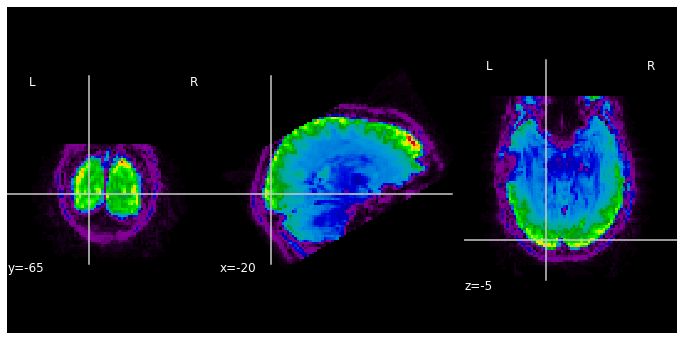

In [4]:
xyz = [-20, -65, -5]
fig, ax = plt.subplots(figsize=(12, 6))
avg_img = mean_img(m)
plot_epi(avg_img, cut_coords=xyz, axes=ax)
fig.show()

In [14]:
masker = NiftiSpheresMasker(seeds=[xyz], radius=None)
masker.fit()
m_data = np.squeeze(masker.transform(m))
p_data = np.squeeze(masker.transform(to_radians(p)))
p_data = np.unwrap(p_data)
c_data = to_complex(m_data, p_data)
r_data = c_data.real
i_data = c_data.imag

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


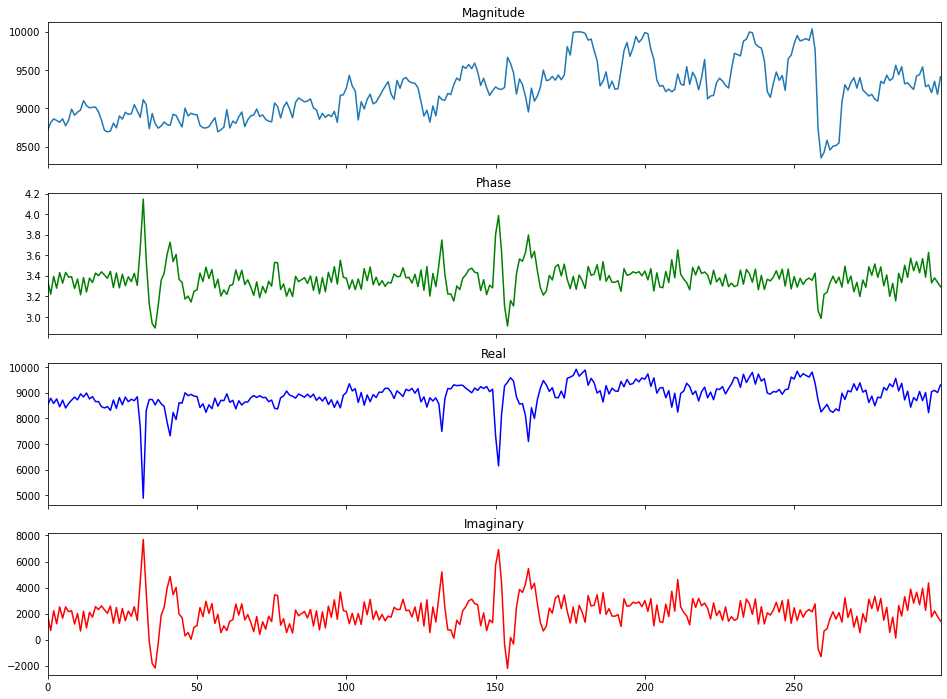

In [15]:
fig, axes = plt.subplots(nrows=4, figsize=(16, 12), sharex=True)
axes[0].plot(m_data)
axes[0].set_title('Magnitude')
axes[1].plot(p_data, color='green')
axes[1].set_title('Phase')
axes[2].plot(r_data, color='blue')
axes[2].set_title('Real')
axes[3].plot(i_data, color='red')
axes[3].set_title('Imaginary')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


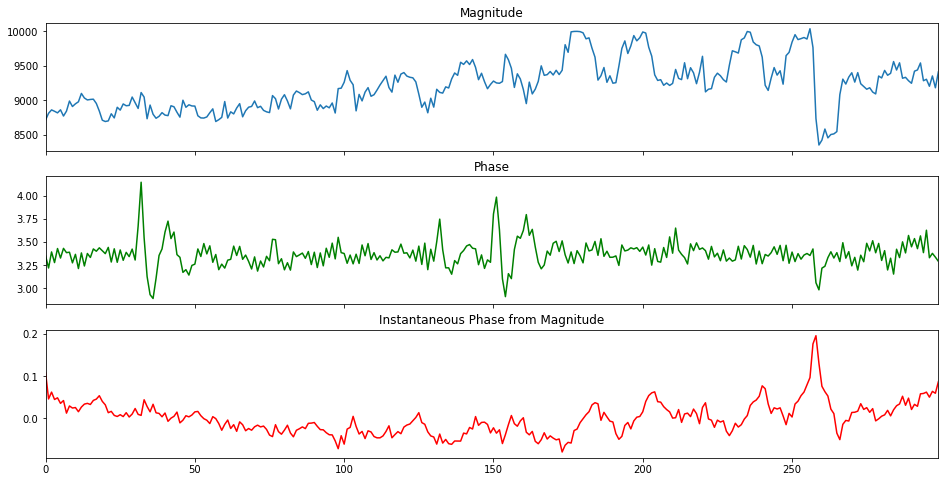

In [7]:
# For the basis for this, see
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
analytic_signal = hilbert(m_data)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

fig, axes = plt.subplots(nrows=3, figsize=(16, 8), sharex=True)
axes[0].plot(m_data)
axes[0].set_title('Magnitude')
axes[1].plot(p_data, color='green')
axes[1].set_title('Phase')
axes[2].plot(instantaneous_phase, color='red')
axes[2].set_title('Instantaneous Phase from Magnitude')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


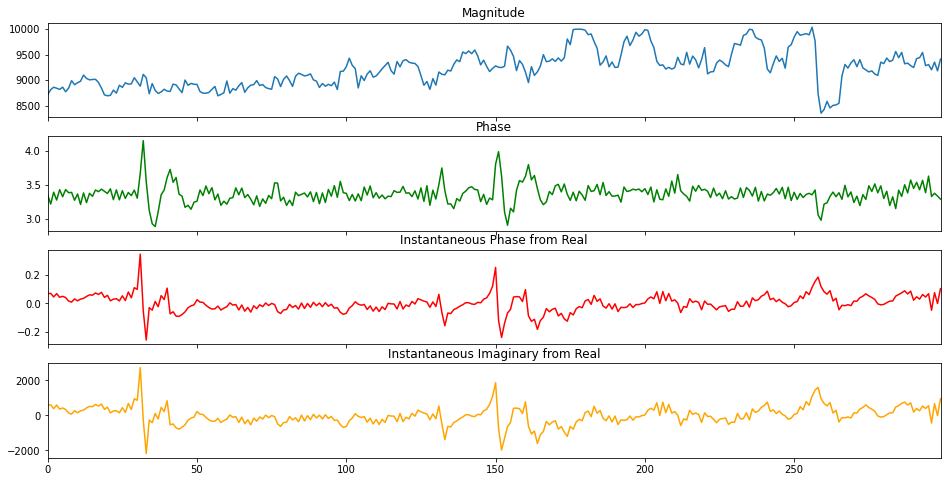

In [32]:
analytic_signal2 = hilbert(r_data)
amplitude_envelope = np.abs(analytic_signal2)
instantaneous_phase2 = np.unwrap(np.angle(analytic_signal2))

fig, axes = plt.subplots(nrows=4, figsize=(16, 8), sharex=True)
axes[0].plot(m_data)
axes[0].set_title('Magnitude')
axes[1].plot(p_data, color='green')
axes[1].set_title('Phase')
axes[2].plot(instantaneous_phase2, color='red')
axes[2].set_title('Instantaneous Phase from Real')
axes[3].plot(analytic_signal2.imag, color='orange')
axes[3].set_title('Instantaneous Imaginary from Real')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

In [34]:
np.corrcoef(i_data, analytic_signal2.imag)

array([[ 1.        , -0.00189004],
       [-0.00189004,  1.        ]])

In [21]:
np.corrcoef(p_data, instantaneous_phase)

array([[ 1.        , -0.06857126],
       [-0.06857126,  1.        ]])

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


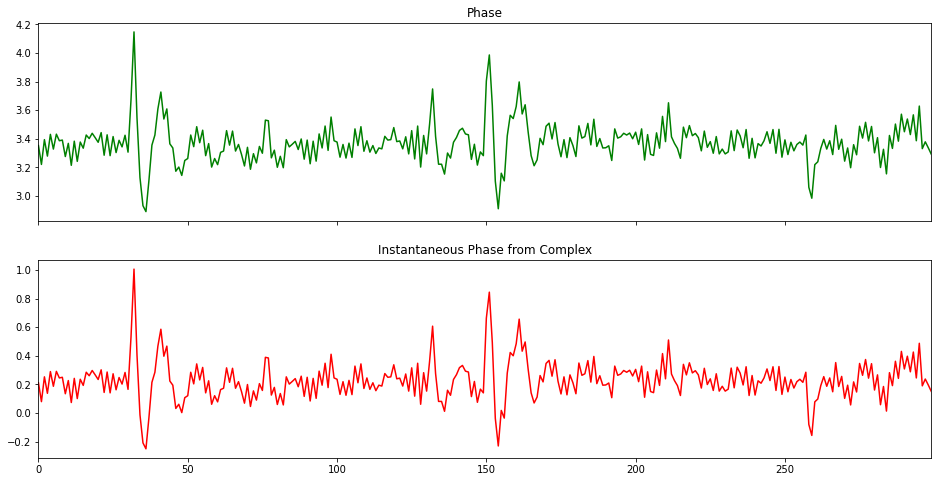

In [24]:
instantaneous_phase_forreal = np.angle(c_data)
fig, axes = plt.subplots(nrows=2, figsize=(16, 8), sharex=True)
axes[0].plot(p_data, color='green')
axes[0].set_title('Phase')
axes[1].plot(instantaneous_phase_forreal, color='red')
axes[1].set_title('Instantaneous Phase from Complex')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

In [26]:
np.corrcoef(i_data, p_data)

array([[1.        , 0.99490298],
       [0.99490298, 1.        ]])

In [27]:
np.corrcoef(r_data, p_data)

array([[ 1.        , -0.58323386],
       [-0.58323386,  1.        ]])

In [28]:
np.corrcoef(m_data, p_data)

array([[1.        , 0.10899002],
       [0.10899002, 1.        ]])

In [29]:
np.corrcoef(m_data, r_data)

array([[1.        , 0.64346738],
       [0.64346738, 1.        ]])

In [30]:
np.corrcoef(m_data, i_data)

array([[1.        , 0.17814554],
       [0.17814554, 1.        ]])